<a href="https://colab.research.google.com/github/tamtemtomm/glovitoo/blob/main/glovitoo_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Essential Import

In [53]:
# @title <p>Essential Import
import os, shutil, json
from PIL import Image
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd, random as rd
import warnings
warnings.filterwarnings("ignore")

In [49]:
# @title <p>Torch Essential Import
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# @title <p> Import kaggle API
from google.colab import files
files.upload()

!unzip data.zip
!rm data.zip >& /dev/null

## Preprocessing Import

In [76]:
# @title <p> Get data from the file
DATA_DIR  = 'data'
DATA_DICT = {}
THRESHOLD = 20

for letter in os.listdir(DATA_DIR):
  for file_data in os.listdir(os.path.join(DATA_DIR, letter)):
    with open(os.path.join(DATA_DIR, letter, file_data), 'r') as f:
      try :
        data = f.read().splitlines()
        DATA_DICT[file_data.split('.')[0]] = data
      except :
        DATA_DICT[file_data.split('.')[0]] = ''

del DATA_DICT['']
len_array = []
for key in DATA_DICT.keys():
  if len(DATA_DICT[key]) < THRESHOLD:
    print(f'Pop data on {key}')
    continue
  else :
    for i, data in enumerate(DATA_DICT[key]):
      try :
        DATA_DICT[key][i] = [float(x) for x in data.split(", ")]
      except :
        continue

  len_array.append(len(DATA_DICT[key]))


<Axes: ylabel='Count'>

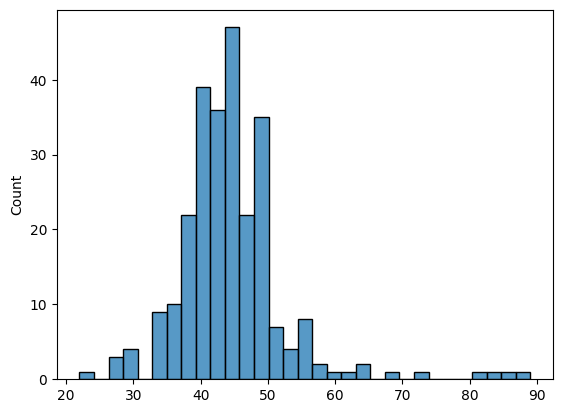

In [77]:
sns.histplot(len_array)